In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import geopandas
import plotly.express as px
import os
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import imageio
import mapclassify
import matplotlib
import matplotlib.image as mpimg
import ast
import json
import numpy as np
import shapely.wkt
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import matplotlib
pd.set_option('display.max_columns', None)
from six.moves import reduce
import scipy
from sklearn.metrics import r2_score
#scipy.stats.pearsonr
import scipy.stats as stats
plt.rcParams.update({'font.family': 'Arial'})
import matplotlib.colors as clr
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from sklearn.cluster import *
from sklearn.decomposition import PCA
from functools import reduce
import scipy.stats

import math
import sklearn
import sklearn.feature_extraction.text
from sklearn import cluster
from sklearn import metrics
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.decomposition
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.metrics import roc_auc_score
from shapely import wkt
#from mycolorpy import colorlist as mcp
import matplotlib.ticker as mtick
from  matplotlib.colors import LinearSegmentedColormap
from functools import reduce
import matplotlib.ticker as plticker
from PIL import Image

In [2]:
variables = ['H_Area_of_store', 
       'R_Percentage_of_Visits_by_brand', 'J_POI_count_where_store_is',
       'K_POI_diversity_where_store_is', 'L_Demographic_similarity',
       'G_Distance_between_cbg_and_store']

In [3]:
vars_definition = {'H_Area_of_store': 'Store area', 
       'R_Percentage_of_Visits_by_brand': 'Chain loyalty', 'J_POI_count_where_store_is': 'POI count',
       'K_POI_diversity_where_store_is': 'POI diversity', 'L_Demographic_similarity': 'Demographic similarity',
       'G_Distance_between_cbg_and_store':'CBG-Store Distance'}

In [4]:
param_2018 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2018/PSO_2018_6params_NYC_norm_28_PSO_15.csv')

param_2019 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2019/PSO_2019_6params_NYC_norm_28_PSO_15.csv')

param_2020 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2020/PSO_2020_6params_NYC_norm_28_PSO_15.csv')

param_2021 = pd.read_csv(
    'data/3_PSO_results/PSO_calirabtion_results/norm_PSO_combination_2021/PSO_2021_6params_NYC_norm_28_PSO_15.csv')

In [5]:
dfs = {'param_2018': param_2018,'param_2019': param_2019,'param_2020': param_2020, 'param_2021': param_2021}

In [6]:
for v in variables:
    param_2018 = param_2018.rename(columns = {v: v + '_2018'})
    param_2019 = param_2019.rename(columns = {v: v + '_2019'})
    param_2020 = param_2020.rename(columns = {v: v + '_2020'})
    param_2021 = param_2021.rename(columns = {v: v + '_2021'})

In [7]:
param_2018 = param_2018.drop(columns = ['cost'])
param_2019 = param_2019.drop(columns = ['cost'])
param_2020 = param_2020.drop(columns = ['cost'])
param_2021 = param_2021.drop(columns = ['cost'])

In [8]:
params_as_of_2020 = param_2018[~param_2018.isin(['no visitors']).any(axis=1)].merge(
    param_2019[~param_2019.isin(['no visitors']).any(axis=1)], on = 'cbg').merge(
        param_2020[~param_2020.isin(['no visitors']).any(axis=1)], on = 'cbg')
params_as_of_2021 = param_2019[~param_2019.isin(['no visitors']).any(axis=1)].merge(
    param_2020[~param_2020.isin(['no visitors']).any(axis=1)], on = 'cbg').merge(
    param_2021[~param_2021.isin(['no visitors']).any(axis=1)], on = 'cbg')

In [9]:
for c in params_as_of_2020.columns:
    if '2018' in c or '2019' in c or '2020' in c:
        params_as_of_2020[c] = params_as_of_2020[c].astype(float)

In [10]:
for c in params_as_of_2021.columns:
    if '2019' in c or '2020' in c or '2021' in c:
        params_as_of_2021[c] = params_as_of_2021[c].astype(float)

In [11]:
clusters = geopandas.read_file(
    'data/4_analysis/census_info_with_kmeans_label.shp')

In [12]:
useful_cbgs = clusters['cbg'].tolist()
params_as_of_2020 = params_as_of_2020[params_as_of_2020['cbg'].isin(useful_cbgs)]
params_as_of_2021 = params_as_of_2021[params_as_of_2021['cbg'].isin(useful_cbgs)]
print(params_as_of_2020.shape, params_as_of_2021.shape)

(5185, 19) (5185, 19)


In [13]:
cluster_definition = {'1': 'senior white people, with lower education level and mediocre income',
                      '2': 'financially limited young people, most are hispanic',
                      '3': 'less educated experienced people, with average income and most are black',
                      '4': 'senior, less educated and common-income people with most race diversity, half are asian',
                      '5': 'senior, most educated and richest people, most are white'}

In [14]:
for v in variables:
    params_as_of_2020[v + '_delta'] = (params_as_of_2020[v+'_2020'] - params_as_of_2020[v+'_2019']) - (
        params_as_of_2020[v+'_2019'] - params_as_of_2020[v+'_2018'])
    params_as_of_2021[v + '_delta'] = (params_as_of_2021[v+'_2021'] - params_as_of_2021[v+'_2020']) - (
        params_as_of_2021[v+'_2020'] - params_as_of_2021[v+'_2019'])

In [15]:
delta_means = {'2020': {}, '2021': {}}
for i in variables:
    delta_means['2020'][i] = params_as_of_2020[i + '_delta'].mean()
    delta_means['2021'][i] = params_as_of_2021[i + '_delta'].mean()

In [16]:
clusters

,cbg,population,med_ageE,bachelor_d,med_hh_inc,whiteE,blackE,asianE,hispanicE,CL,geometry
0,360050245023,1886,28.9,0.042418,30500.0,0.154295,0.239130,0.000000,0.873807,2.0,"POLYGON ((-73.91542 40.85417, -73.91494 40.855..."
1,360050247002,1318,35.4,0.080425,44524.0,0.045524,0.523520,0.004552,0.502276,2.0,"POLYGON ((-73.92122 40.85469, -73.92096 40.855..."
2,360050253004,1222,26.6,0.044190,36250.0,0.094108,0.036825,0.000000,0.945172,2.0,"POLYGON ((-73.90707 40.85936, -73.90404 40.862..."
3,360050263005,1941,63.8,0.156620,12351.0,0.311180,0.220505,0.000000,0.459042,2.0,"POLYGON ((-73.90439 40.86590, -73.90236 40.868..."
4,360050265004,1191,28.2,0.073048,38099.0,0.028547,0.223342,0.073887,0.748950,2.0,"POLYGON ((-73.90194 40.86455, -73.90059 40.866..."
...,...,...,...,...,...,...,...,...,...,...,...
5180,360850213002,987,27.0,0.095238,53445.0,0.470111,0.453901,0.025329,0.424519,2.0,"POLYGON ((-74.14149 40.63326, -74.14128 40.633..."
5181,360850036002,1087,41.6,0.249310,63563.0,0.625575,0.000000,0.300828,0.252070,1.0,"POLYGON ((-74.07898 40.60708, -74.07880 40.607..."
5182,360850040007,1854,33.8,0.151025,49703.0,0.199029,0.367853,0.160734,0.291802,2.0,"POLYGON ((-74.07695 40.62016, -74.07558 40.620..."
5183,360850006002,1995,55.4,0.306767,51964.0,0.696241,0.117293,0.112281,0.198997,1.0,"POLYGON ((-74.06613 40.61409, -74.06316 40.615..."


In [17]:
params_as_of_2020 = params_as_of_2020.merge(clusters[['cbg', 'CL']], how = 'inner').dropna()
params_as_of_2021 = params_as_of_2021.merge(clusters[['cbg', 'CL']], how = 'inner').dropna()

In [18]:
print(params_as_of_2020.shape, params_as_of_2021.shape)

(5185, 26) (5185, 26)


In [19]:
delta_means

{'2020': {'H_Area_of_store': 3.312165964718729,
  'R_Percentage_of_Visits_by_brand': 2.953779771551382,
  'J_POI_count_where_store_is': 1.1193077623374432,
  'K_POI_diversity_where_store_is': 0.812093046194162,
  'L_Demographic_similarity': 0.1266466371490986,
  'G_Distance_between_cbg_and_store': -2.335124345993731},
 '2021': {'H_Area_of_store': -3.2353826130967995,
  'R_Percentage_of_Visits_by_brand': -2.9937514996563936,
  'J_POI_count_where_store_is': -0.5318805217857605,
  'K_POI_diversity_where_store_is': -0.634628994321539,
  'L_Demographic_similarity': -0.1706190786289293,
  'G_Distance_between_cbg_and_store': 1.0493544030336366}}

In [20]:
params_as_of_2021

,cbg,H_Area_of_store_2019,R_Percentage_of_Visits_by_brand_2019,J_POI_count_where_store_is_2019,K_POI_diversity_where_store_is_2019,L_Demographic_similarity_2019,G_Distance_between_cbg_and_store_2019,H_Area_of_store_2020,R_Percentage_of_Visits_by_brand_2020,J_POI_count_where_store_is_2020,K_POI_diversity_where_store_is_2020,L_Demographic_similarity_2020,G_Distance_between_cbg_and_store_2020,H_Area_of_store_2021,R_Percentage_of_Visits_by_brand_2021,J_POI_count_where_store_is_2021,K_POI_diversity_where_store_is_2021,L_Demographic_similarity_2021,G_Distance_between_cbg_and_store_2021,H_Area_of_store_delta,R_Percentage_of_Visits_by_brand_delta,J_POI_count_where_store_is_delta,K_POI_diversity_where_store_is_delta,L_Demographic_similarity_delta,G_Distance_between_cbg_and_store_delta,CL
0,360810265001,1.489843,8.547292,2.176574,7.905327,5.910468,7.522902,6.471489,7.468026,7.811008,3.533569,9.043607,2.691734,2.397869,11.058171,2.731936,4.606179,12.469950,1.385244,-9.055267,4.669410,-10.713505,5.444367,0.293204,3.524678,4.0
1,360810266001,12.895032,12.572163,5.360626,14.849818,7.957661,11.064302,1.253547,6.115876,2.407990,7.548443,1.156790,2.067505,7.334859,13.698827,14.534354,8.572003,11.449166,3.264051,17.722797,14.039239,15.079001,8.324934,17.093246,10.193343,3.0
2,360810267003,4.114652,3.771660,1.323340,1.010250,12.632961,8.572359,13.544477,14.195765,12.478323,1.912082,1.879299,13.203268,1.361979,9.789652,11.481606,9.586060,11.791978,13.213394,-21.612324,-14.830219,-12.151701,6.772146,20.666340,-4.620783,4.0
3,360810267002,3.725740,1.243766,1.048023,12.233843,10.389466,9.643790,13.327835,14.855539,7.001841,7.456564,10.957115,14.698640,1.042063,13.130901,1.114101,5.752905,11.379420,11.095787,-21.887866,-15.336411,-11.841558,3.073621,-0.145343,-8.657703,4.0
4,360810267001,1.967663,1.336961,2.346132,10.364556,8.385400,9.172186,1.917150,12.437993,6.823745,10.640202,14.787364,9.601534,14.260576,8.598317,1.955068,11.689363,12.515469,9.898017,12.393940,-14.940709,-9.346291,0.773515,-8.673859,-0.132865,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5180,360050332013,5.448276,10.687780,6.472112,4.293162,6.287781,14.660989,9.272017,14.356186,9.357051,4.106838,1.063167,1.304419,14.822386,11.925168,2.169978,3.618584,7.984731,12.654479,1.726628,-6.099424,-10.072012,-0.301931,12.146179,24.706630,2.0
5181,360050332021,1.683654,5.896146,8.972888,7.304690,9.696036,10.786912,1.815364,4.886041,12.662856,9.473954,5.524410,4.815825,4.211403,13.281992,14.703188,10.707319,12.736033,9.960592,2.264330,9.406056,-1.649637,-0.935898,11.383249,11.115854,2.0
5182,360050332022,9.190281,9.661315,9.290822,7.031689,1.589167,11.404483,3.291246,4.089330,14.969835,3.596851,2.515546,9.202005,13.003282,13.645087,2.339146,12.785955,11.157818,8.443219,15.611071,15.127742,-18.309702,12.623943,7.715894,1.443692,2.0
5183,360050332023,3.873589,7.396719,10.159913,14.244325,10.970018,12.387950,1.832074,6.468315,13.309468,3.149941,3.058037,4.425140,2.514242,13.995935,14.929097,3.555978,14.486119,7.740324,2.723683,8.456025,-1.529925,11.500420,19.340064,11.277995,3.0


In [21]:
vars_definition

{'H_Area_of_store': 'Store area',
 'R_Percentage_of_Visits_by_brand': 'Chain loyalty',
 'J_POI_count_where_store_is': 'POI count',
 'K_POI_diversity_where_store_is': 'POI diversity',
 'L_Demographic_similarity': 'Demographic similarity',
 'G_Distance_between_cbg_and_store': 'CBG-Store Distance'}

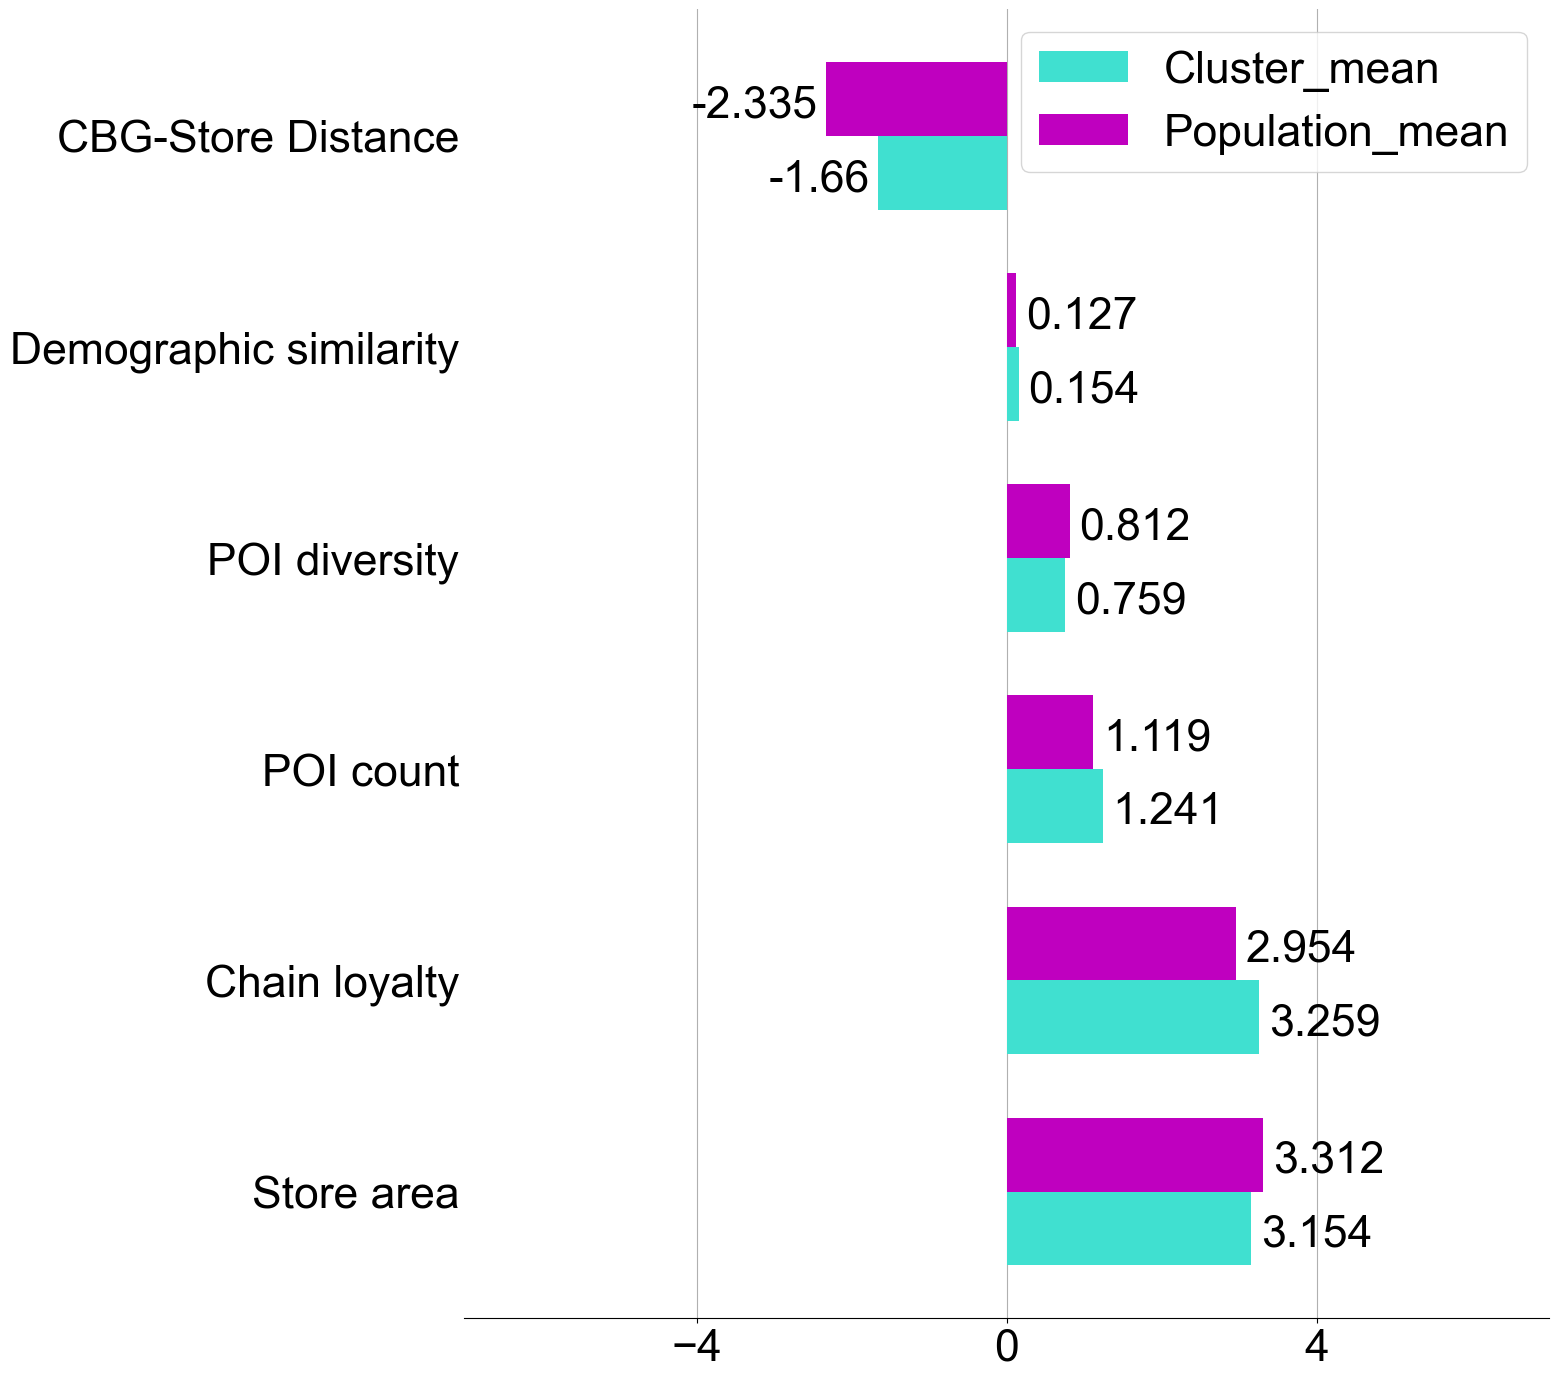

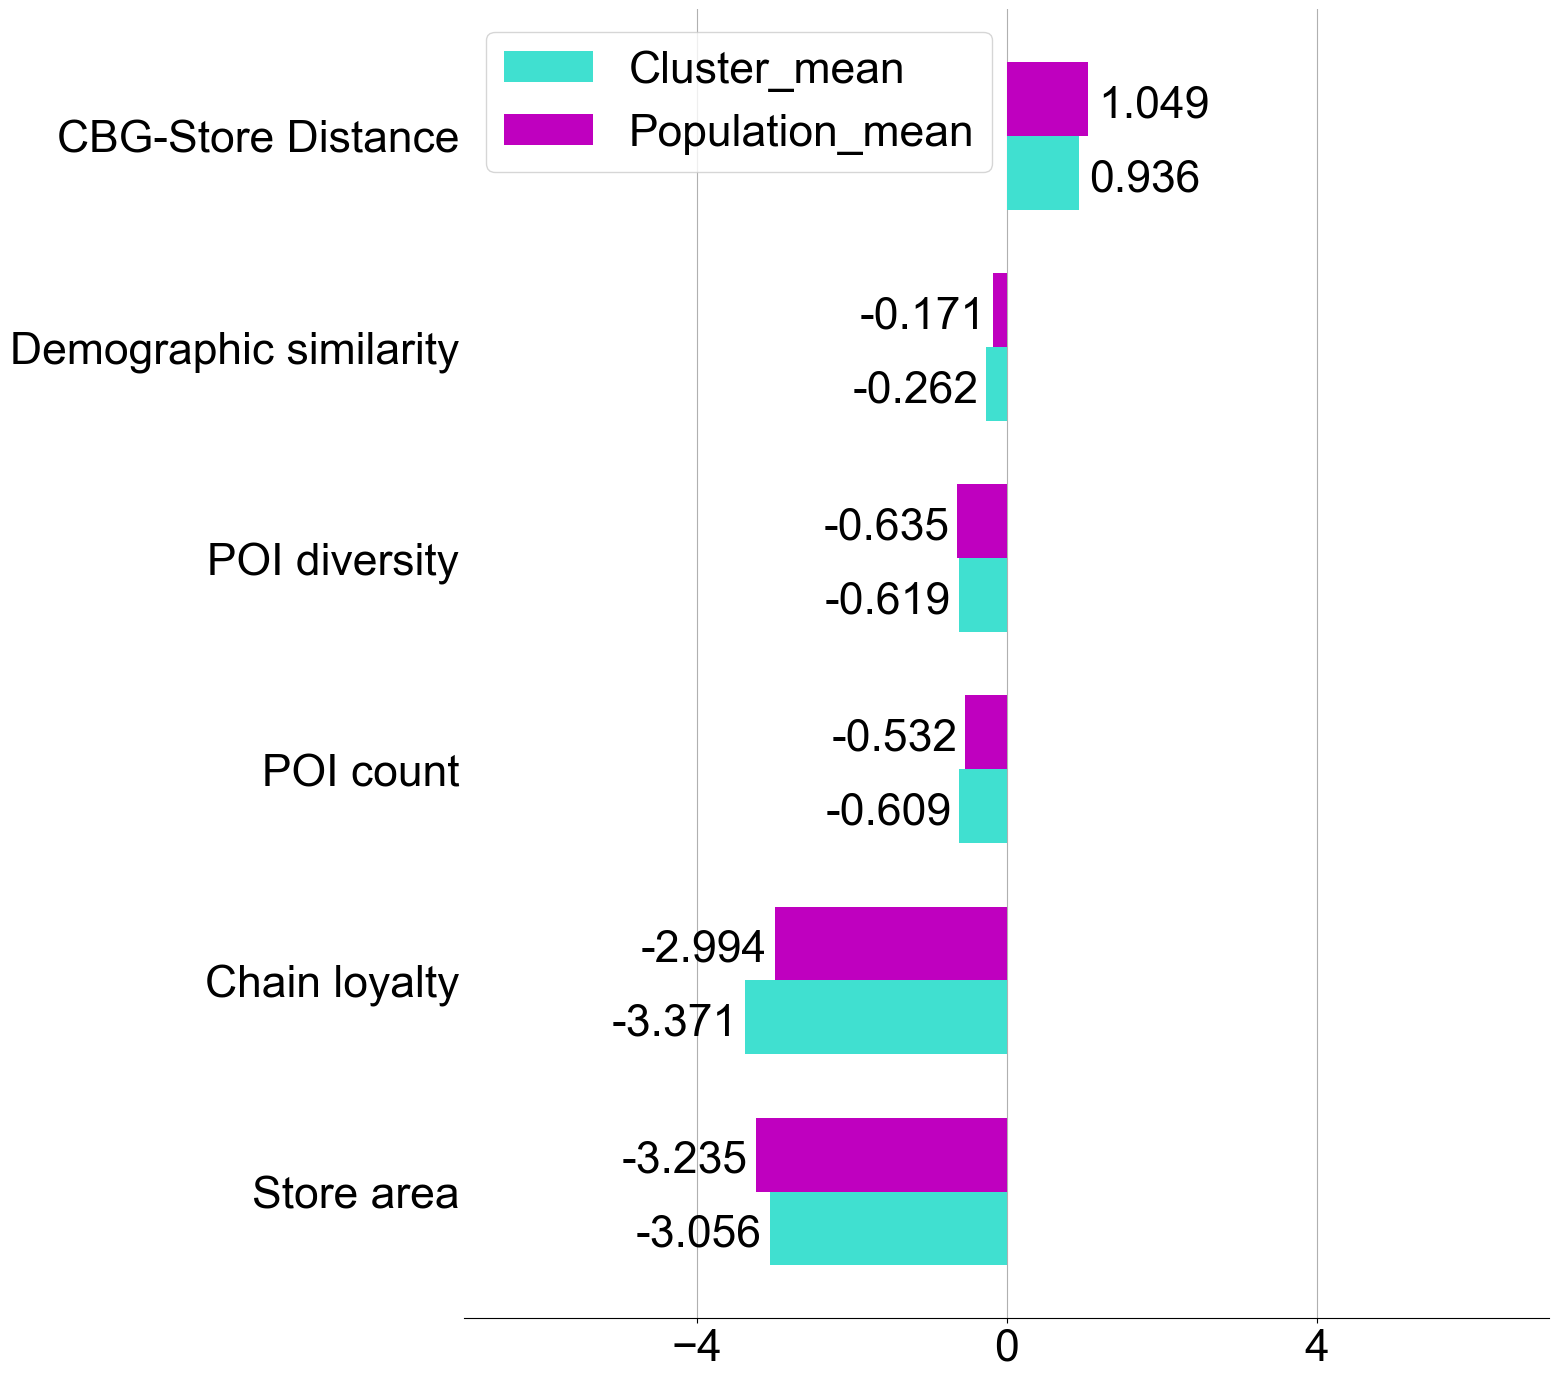

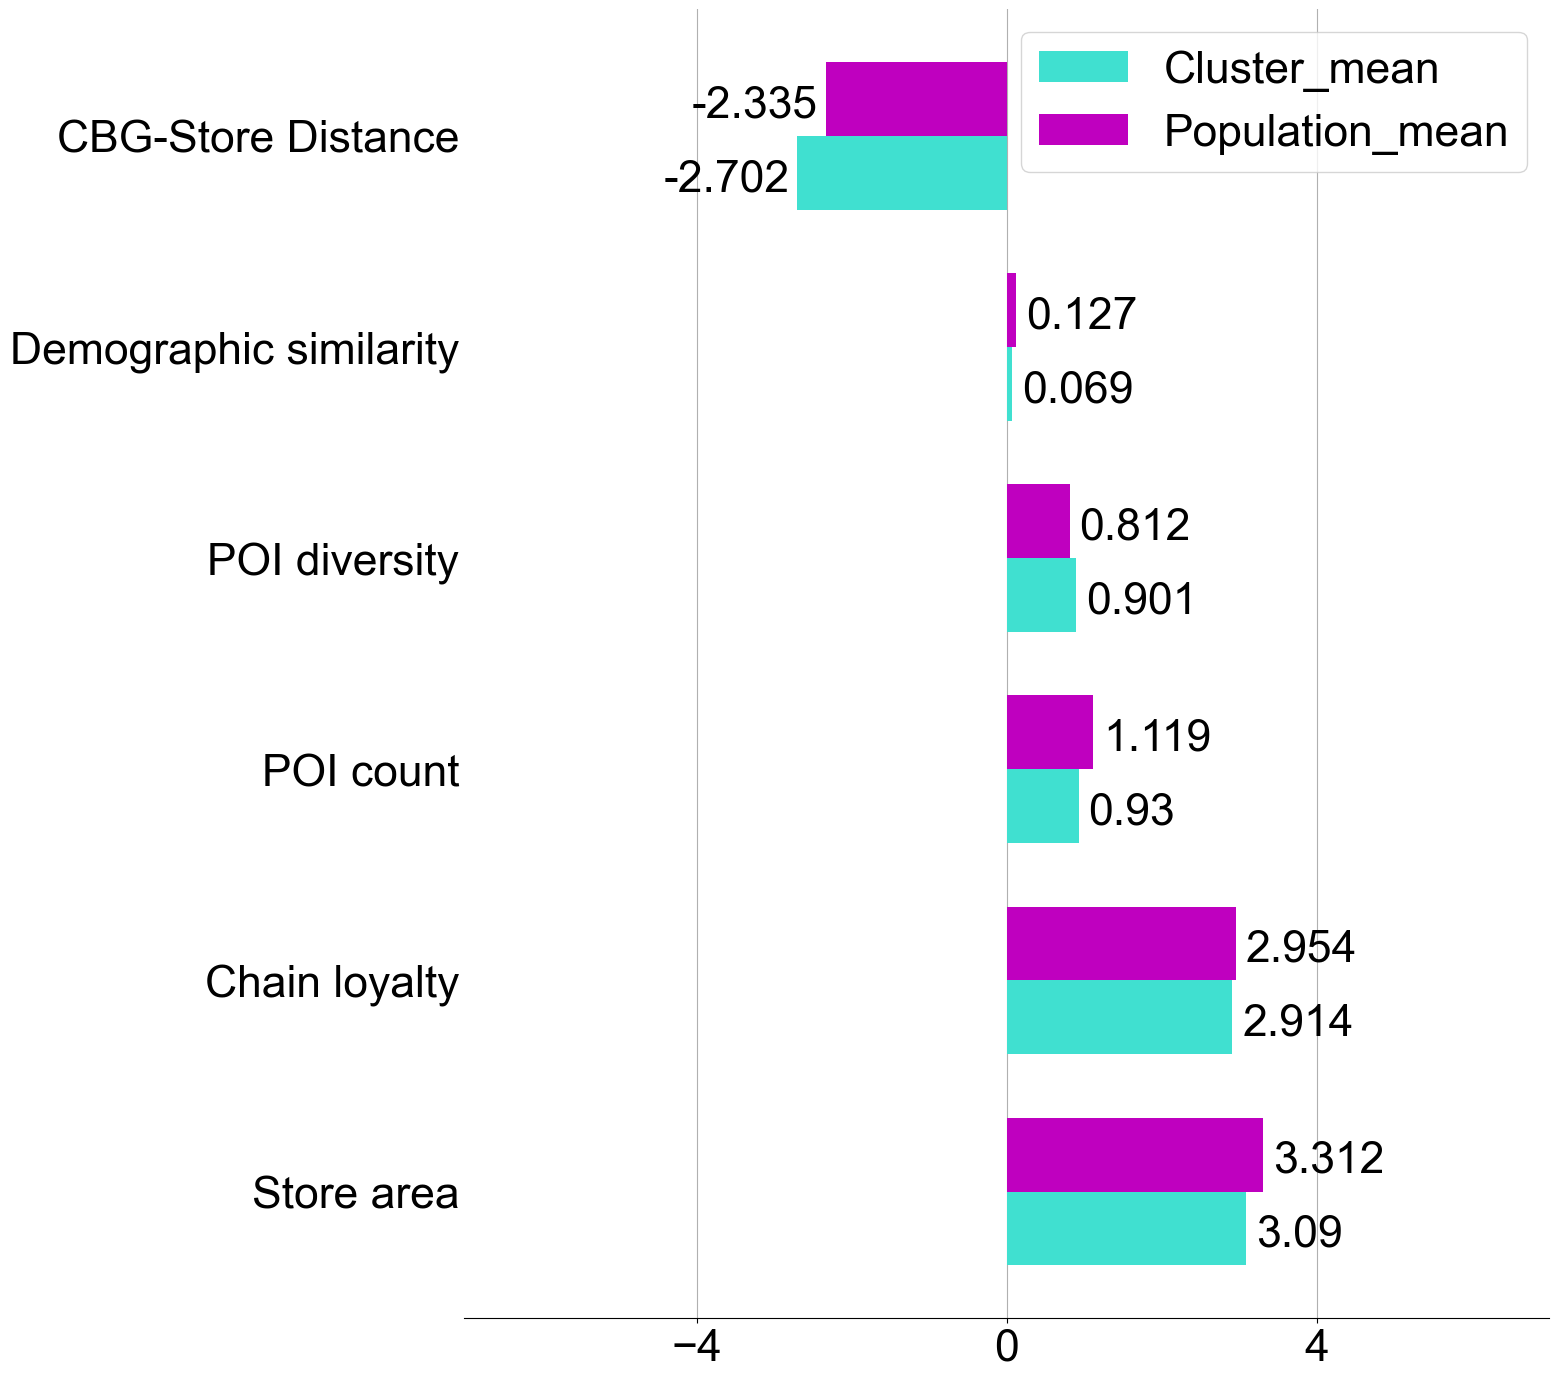

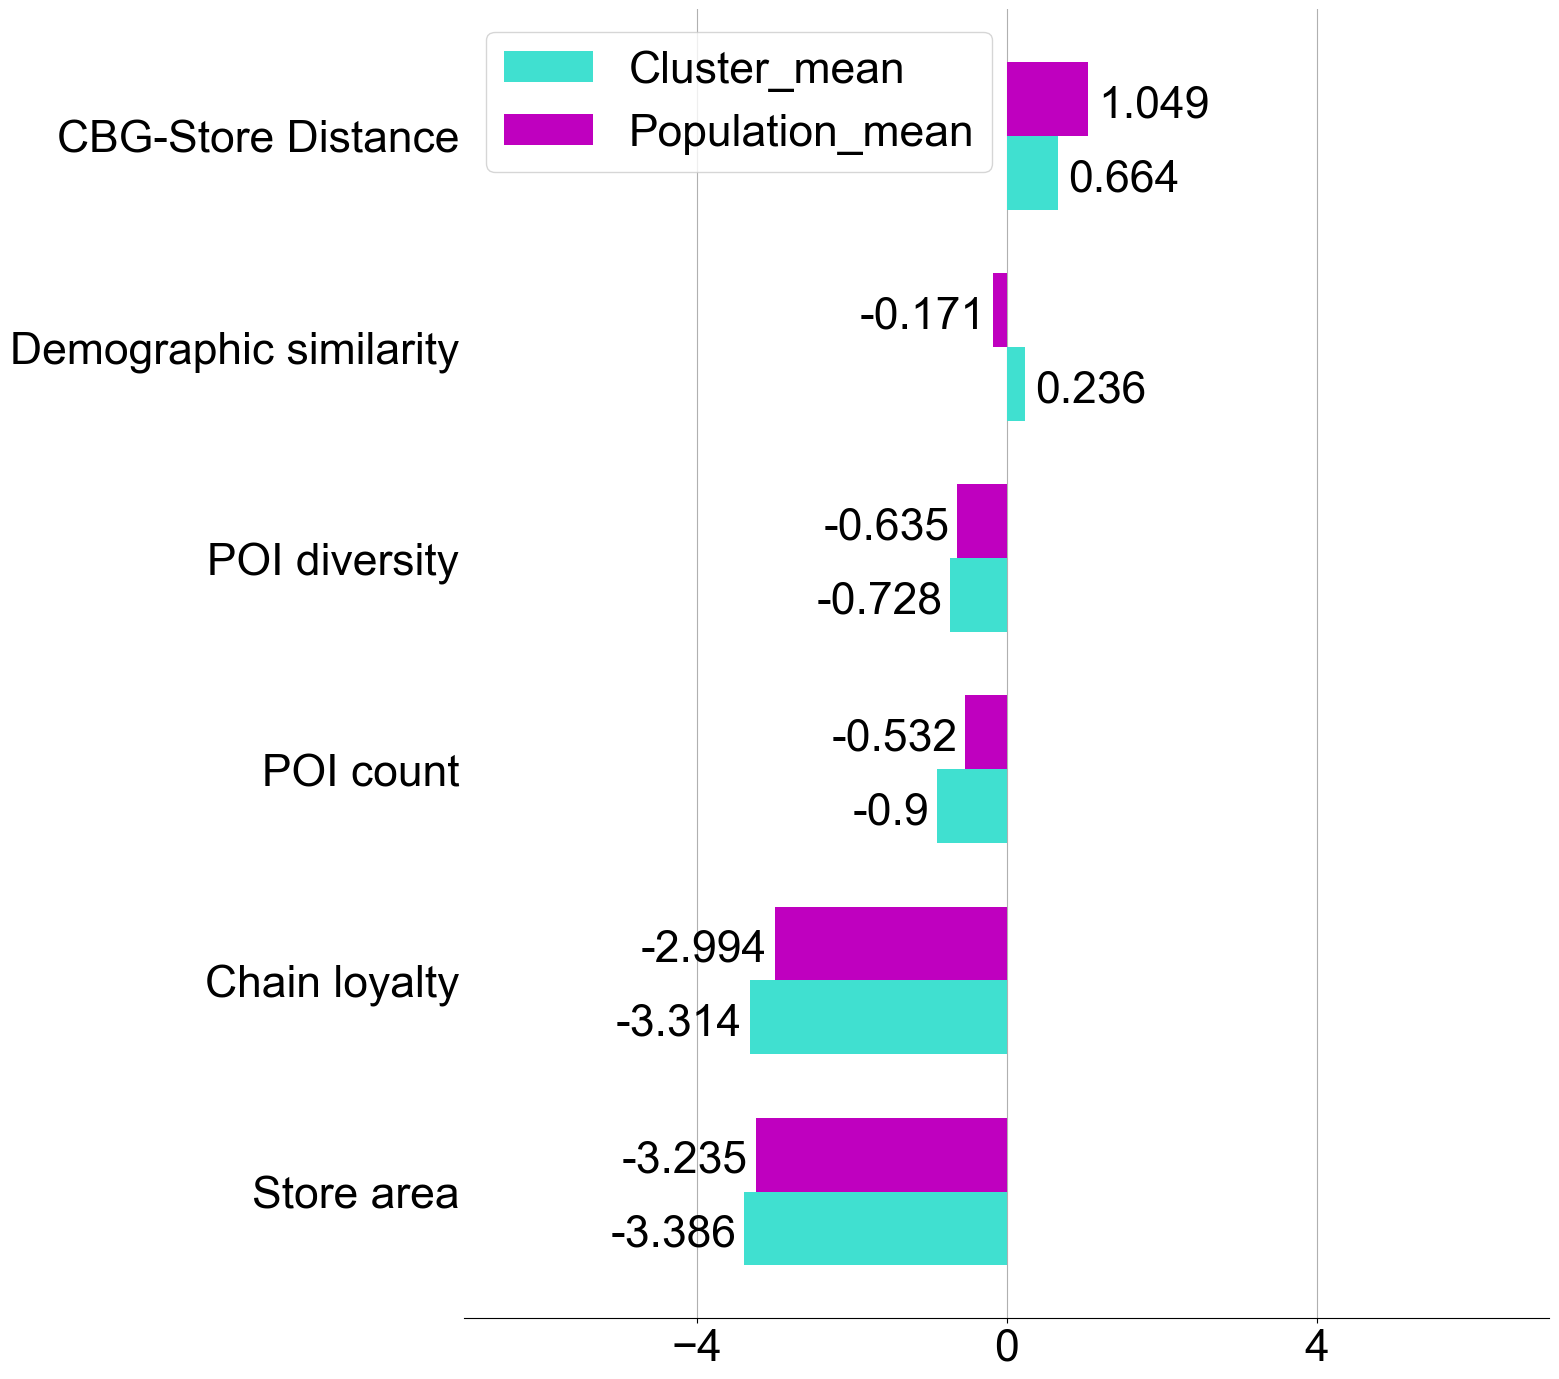

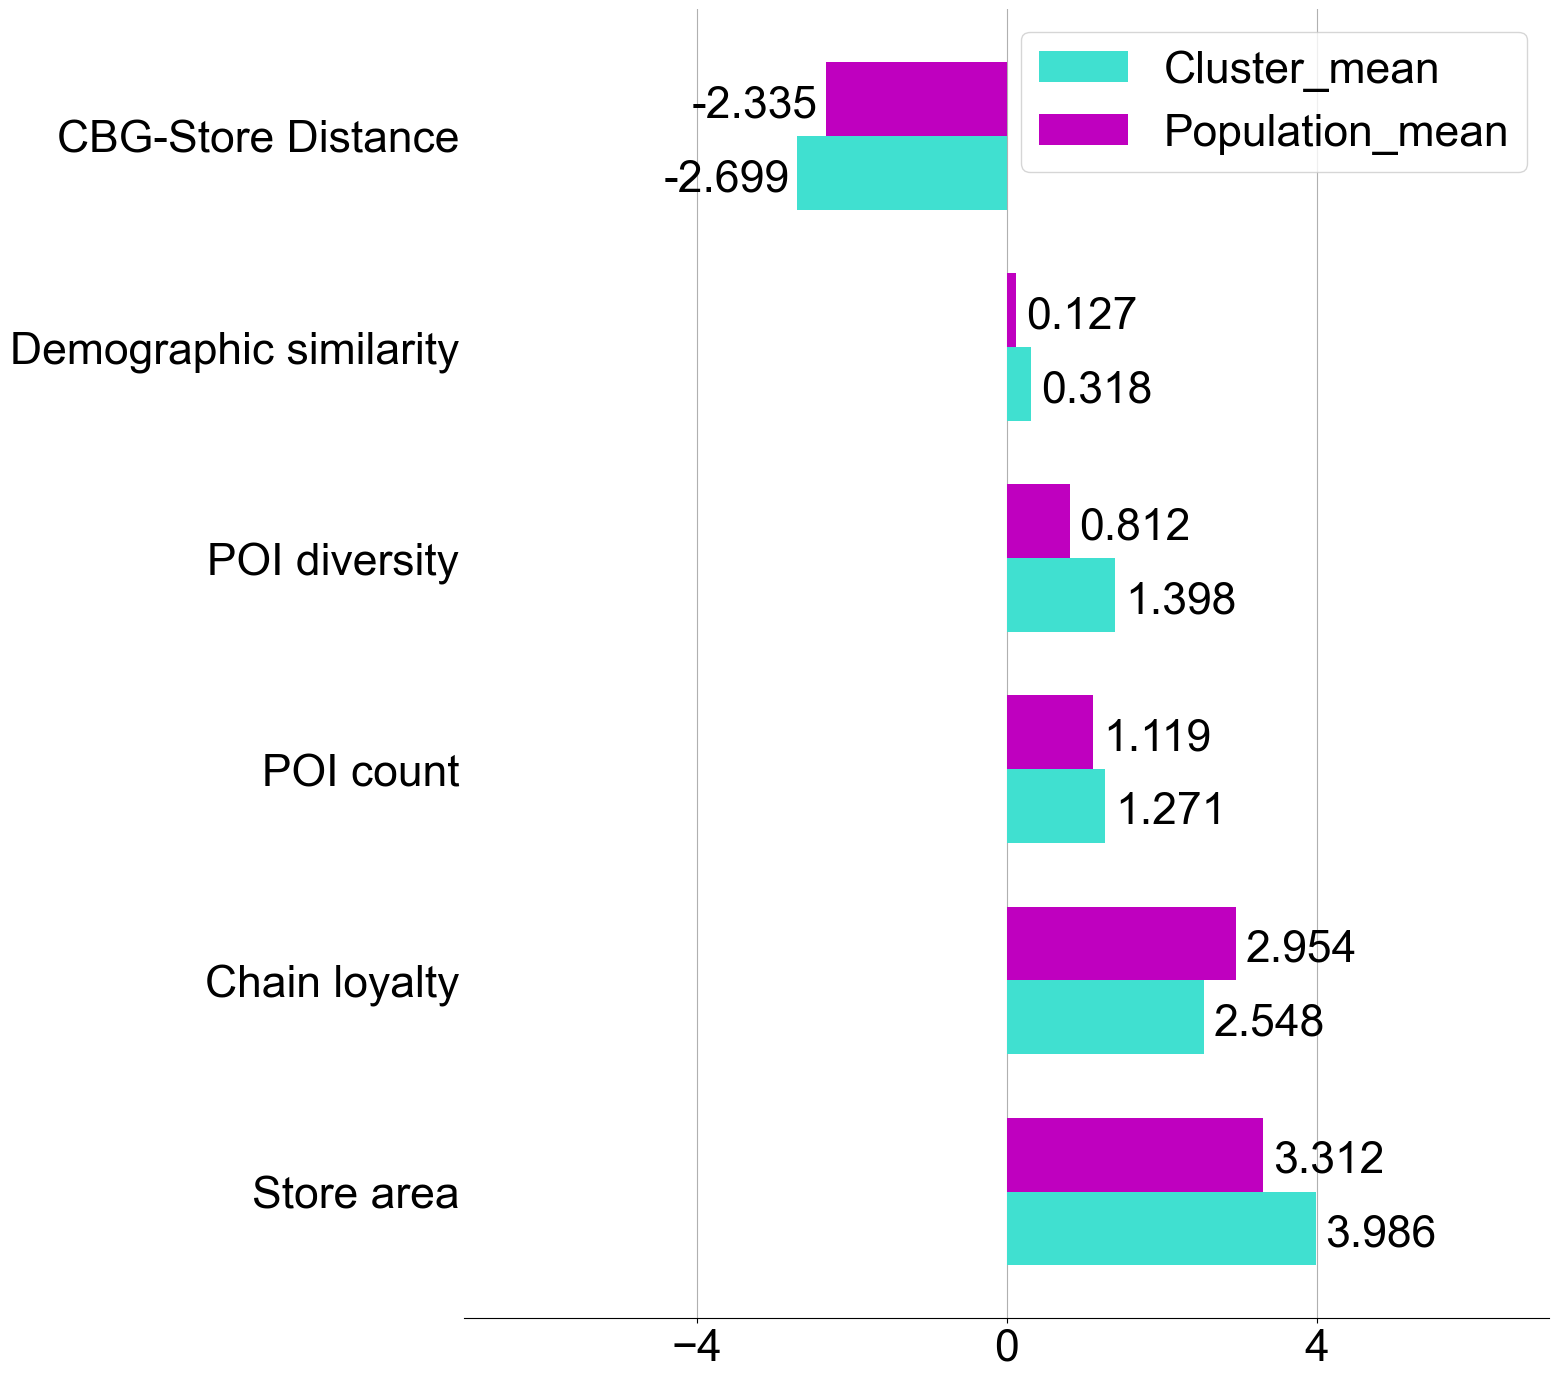

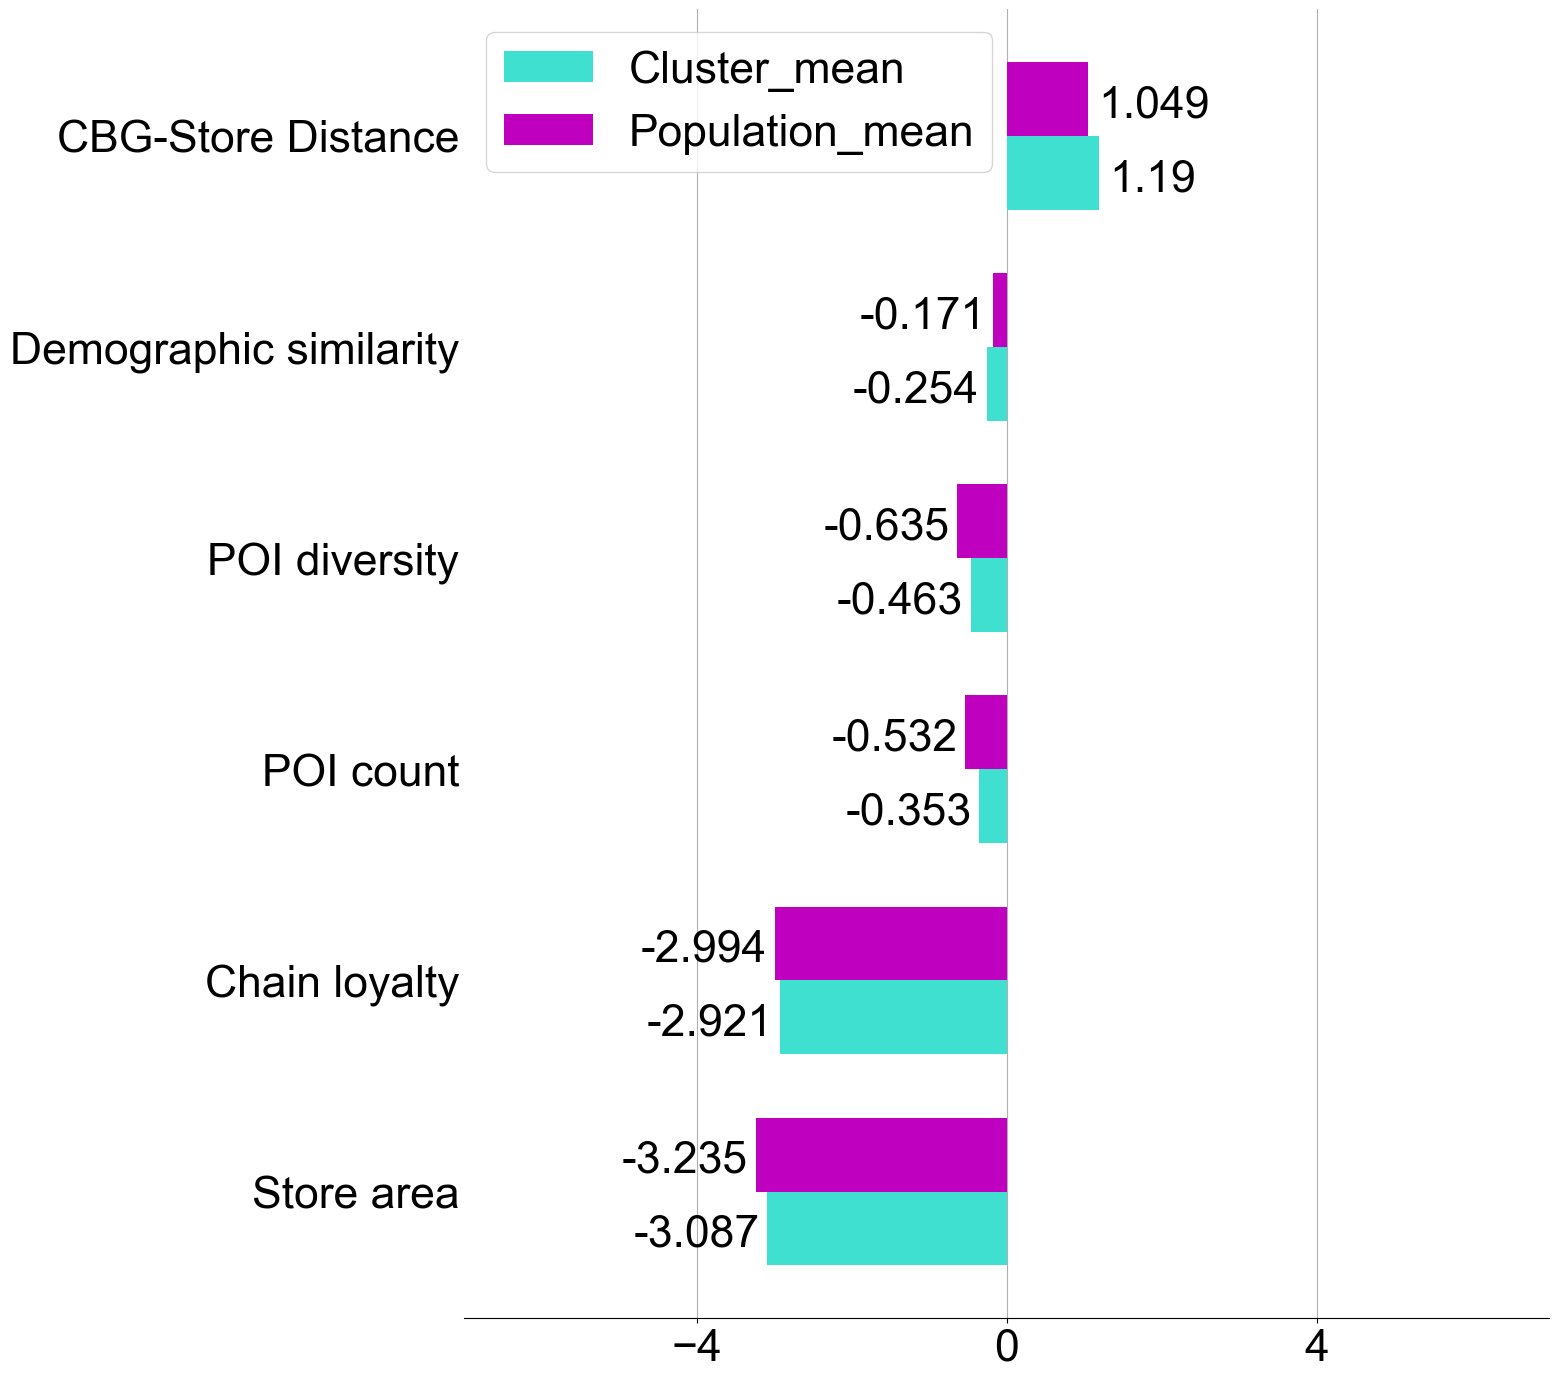

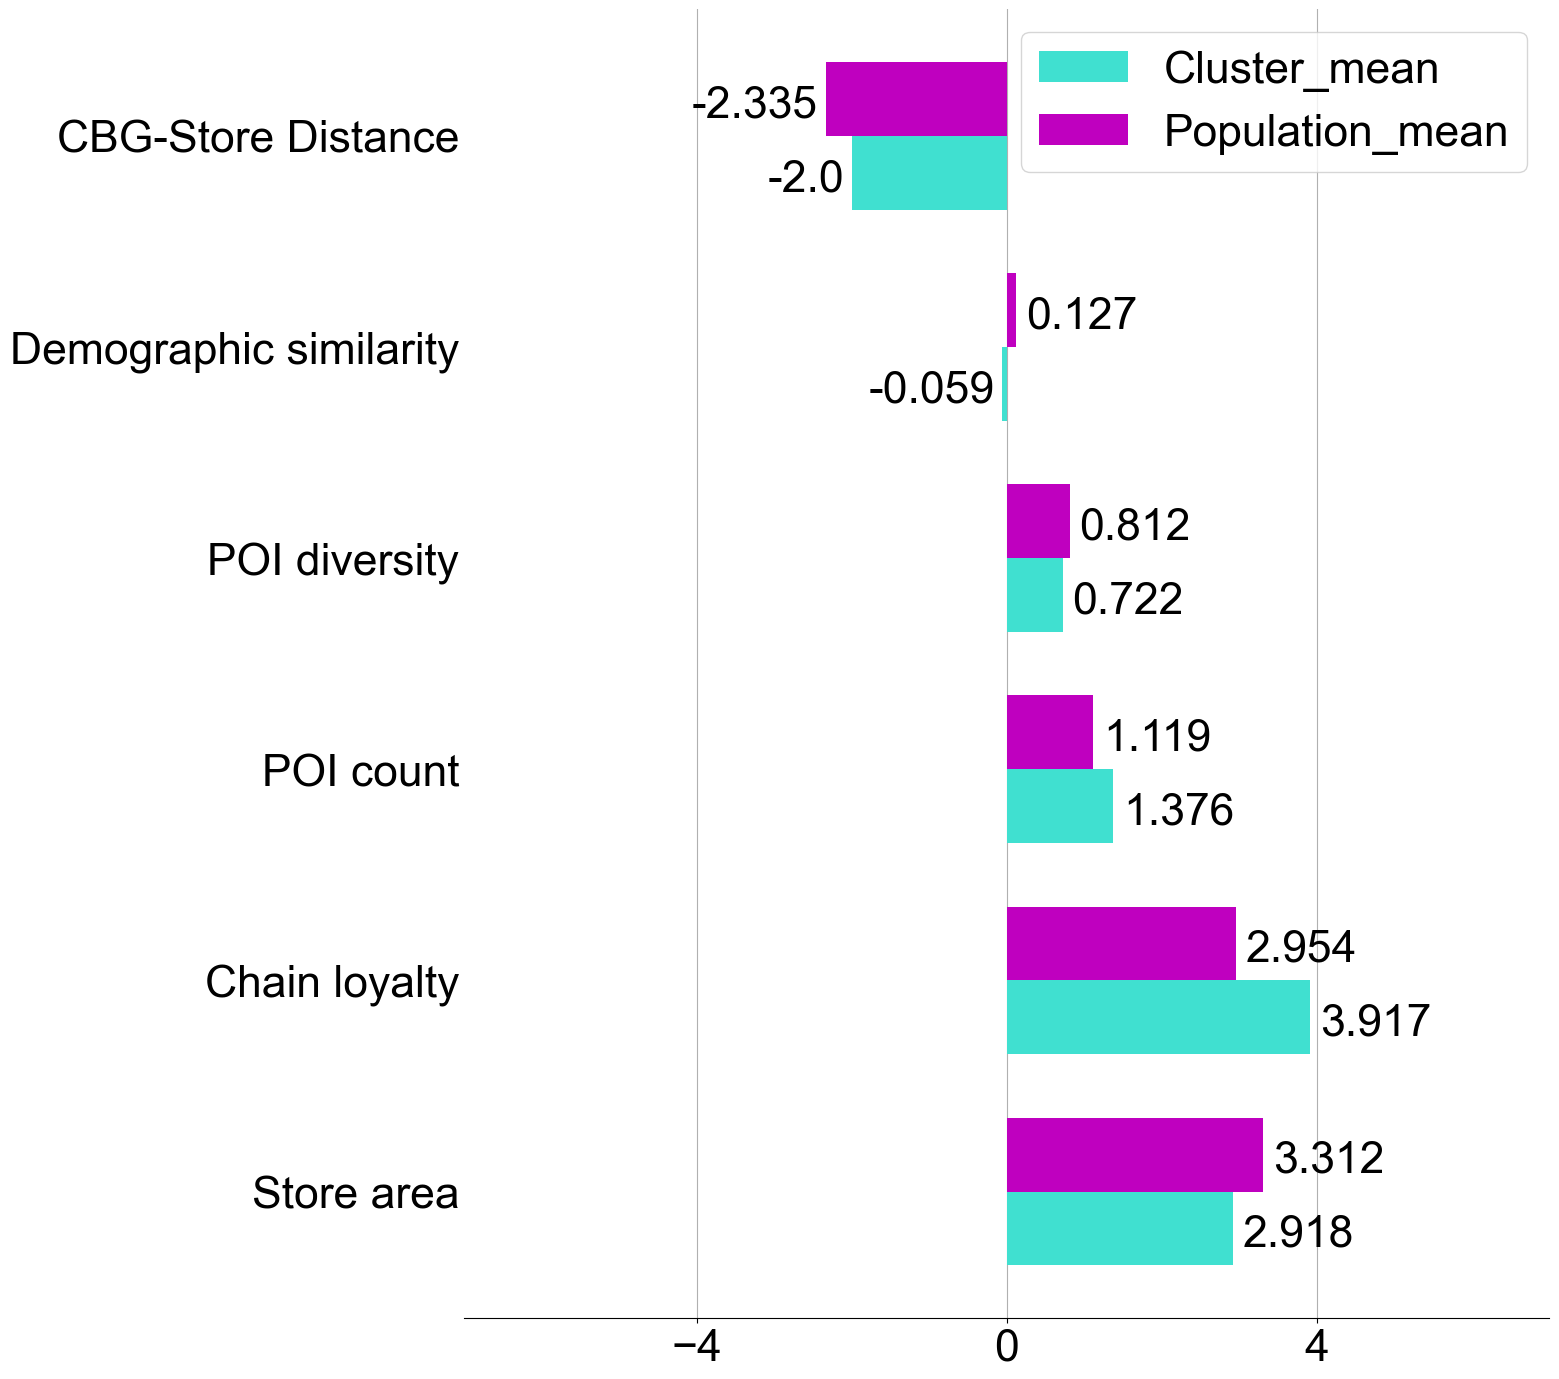

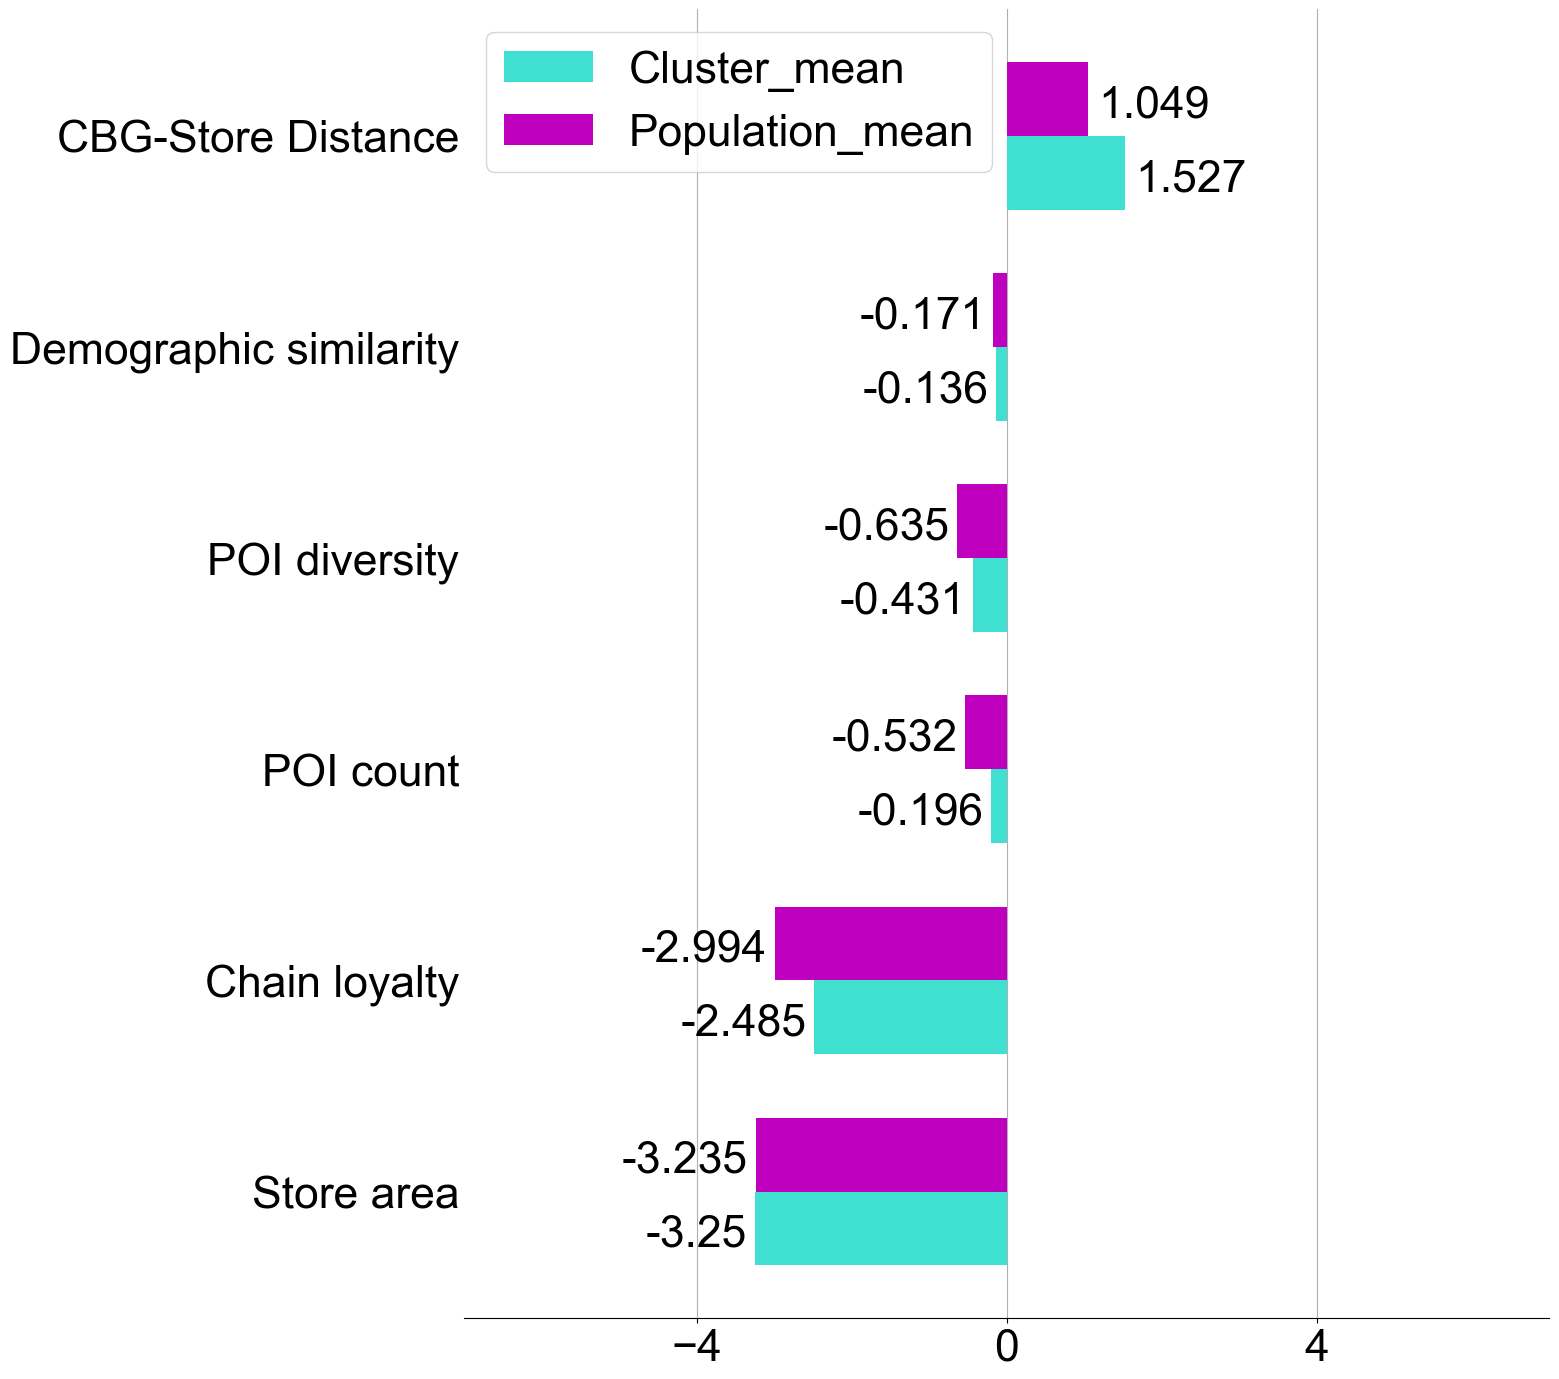

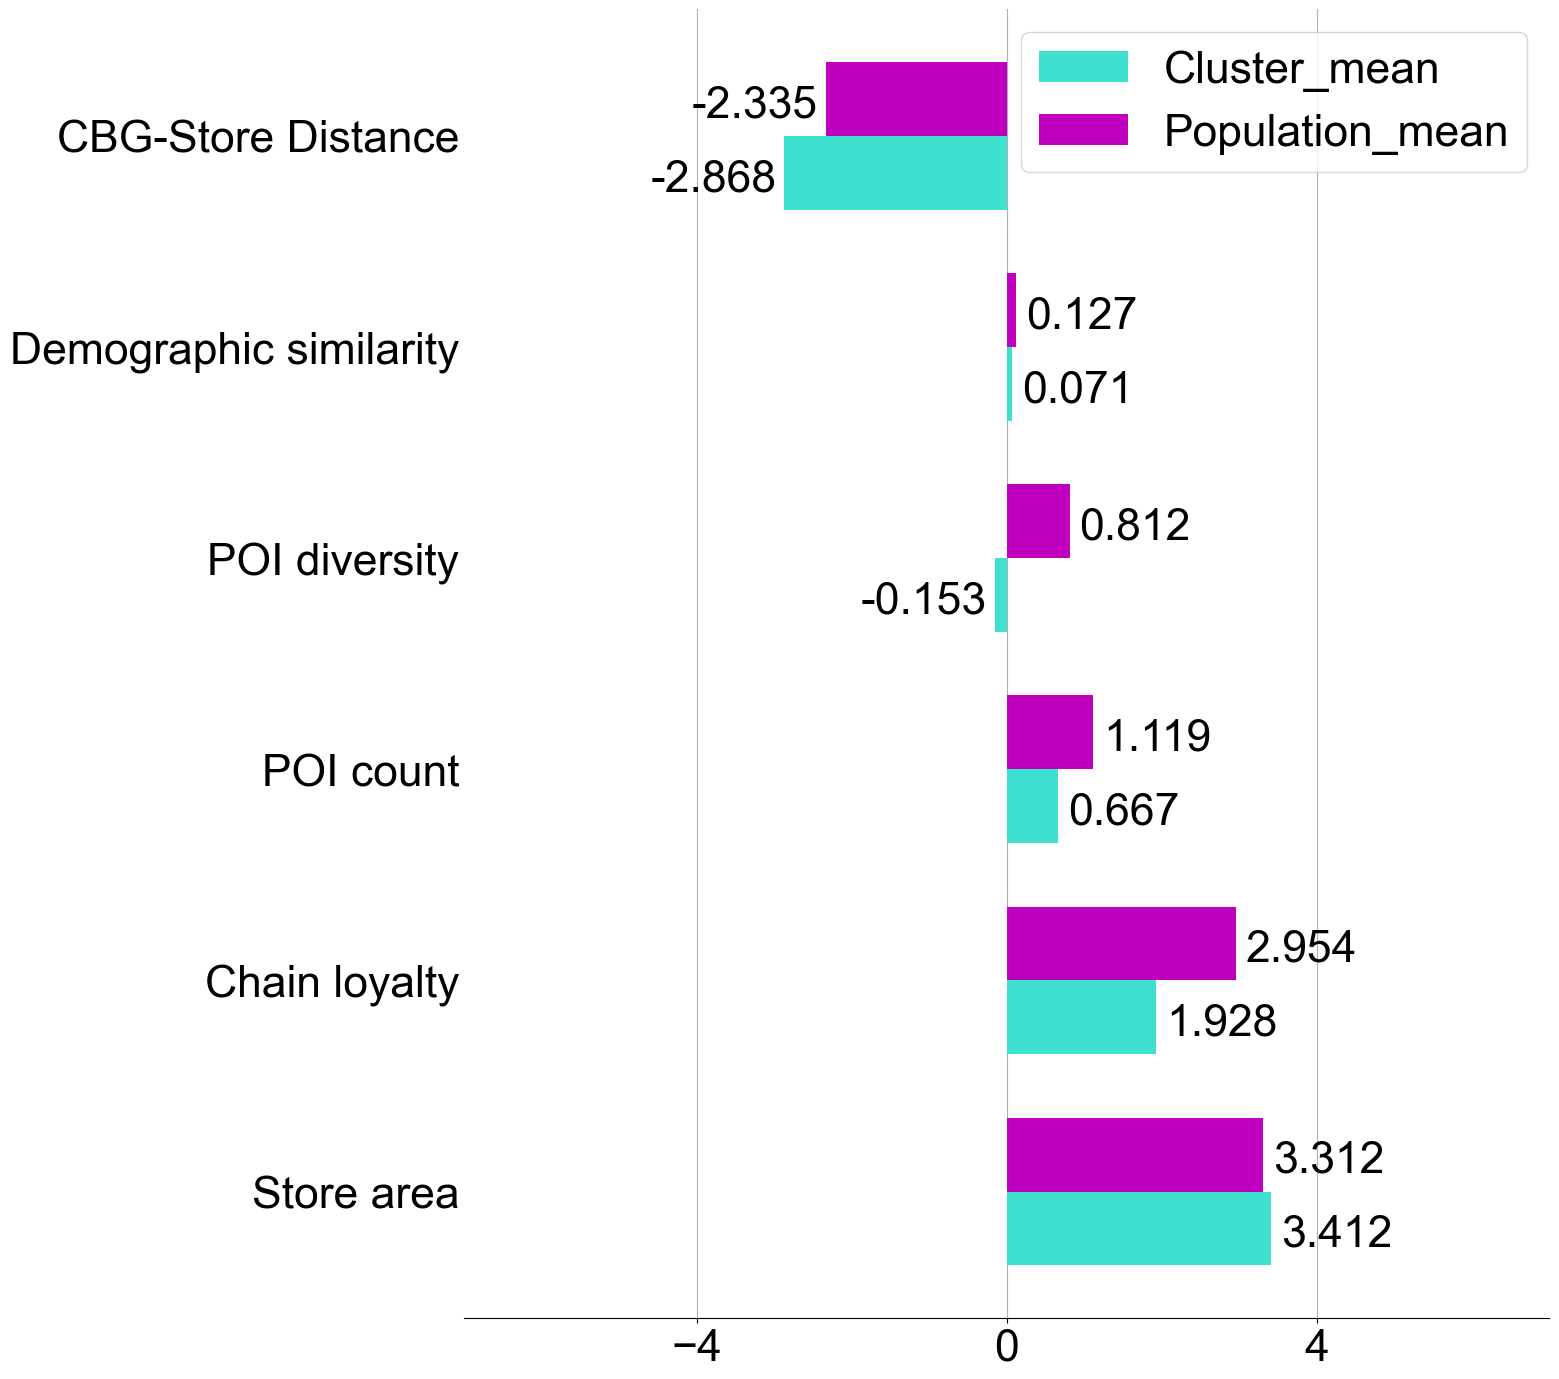

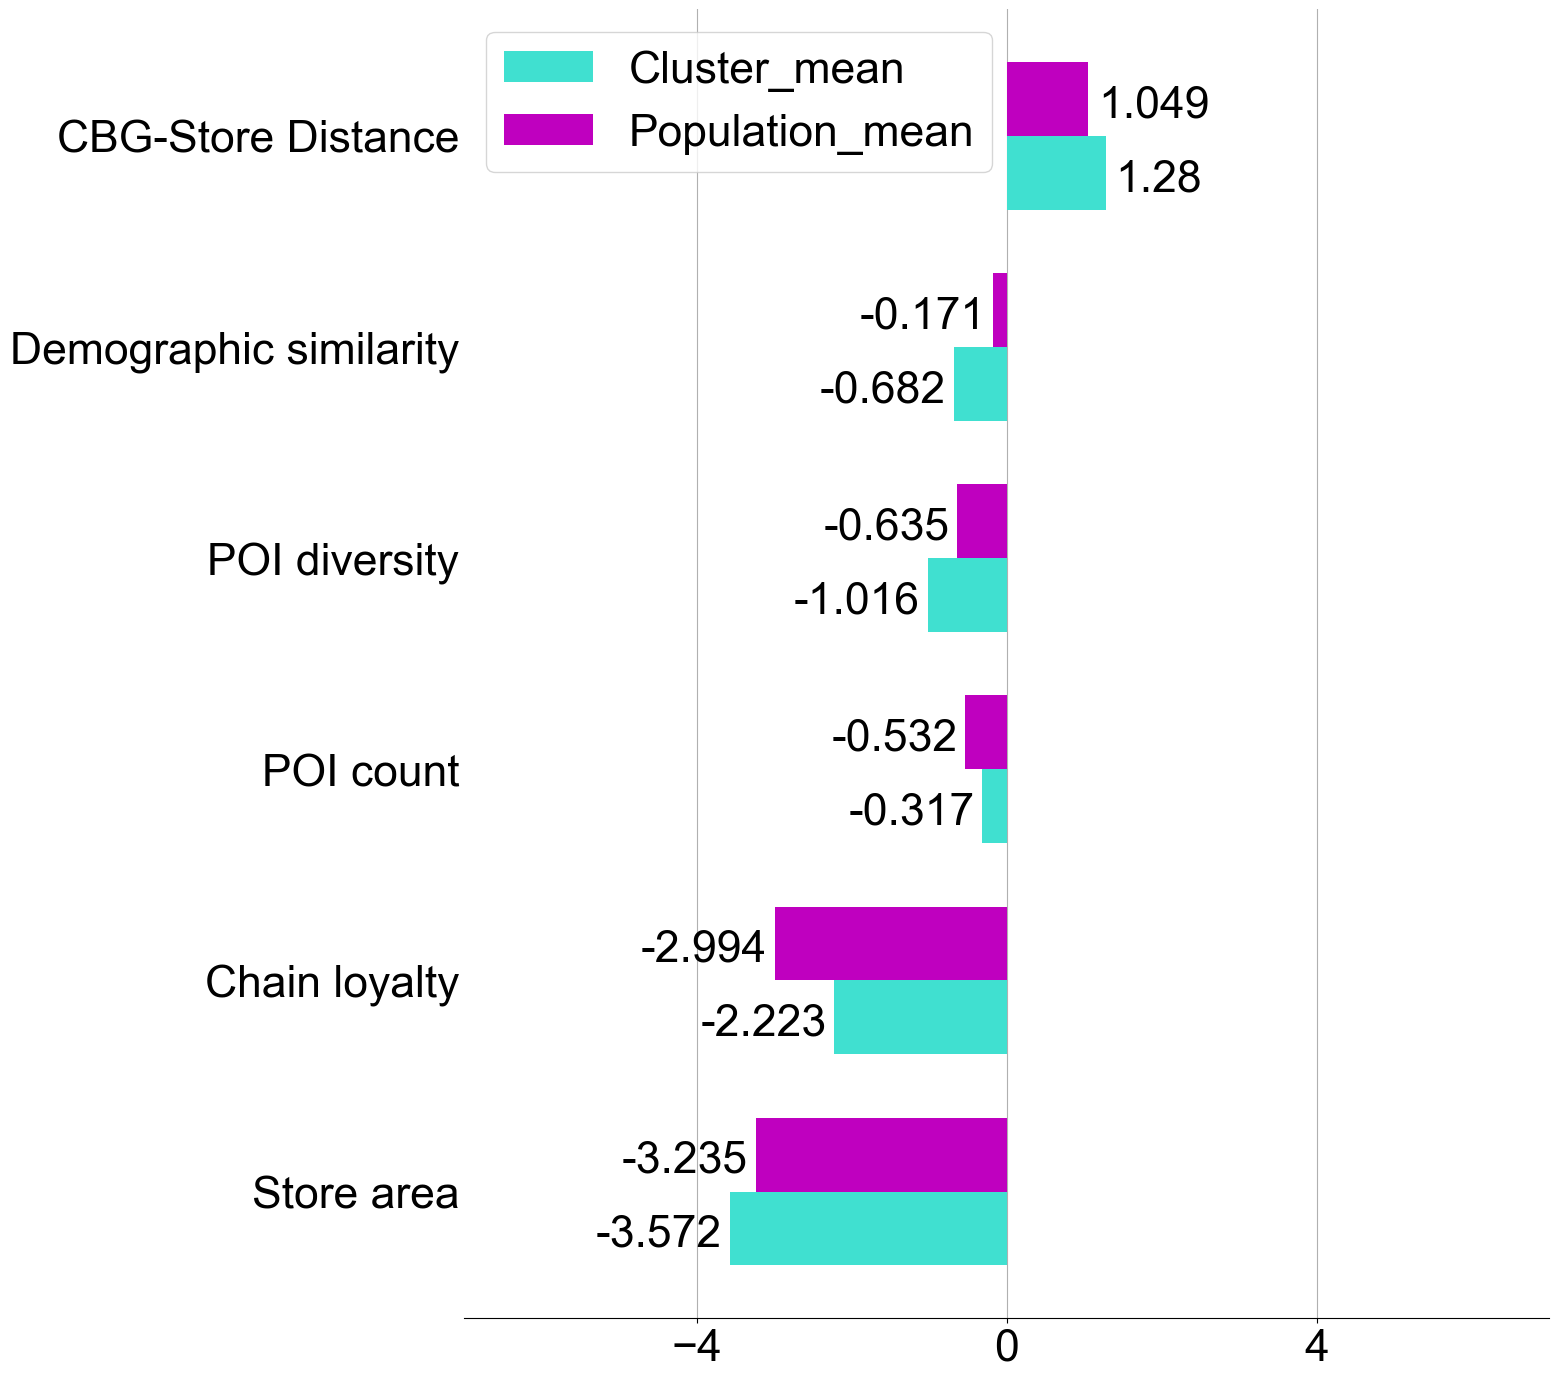

In [22]:
def get_cluster_deltas(cluster_label, as_of_year):

    if as_of_year == 2020:
        d_here = params_as_of_2020[params_as_of_2020['CL'] == cluster_label]
    if as_of_year == 2021:
        d_here = params_as_of_2021[params_as_of_2020['CL'] == cluster_label]
    
    d_here = d_here[[i+'_delta' for i in variables]].mean().reset_index().rename(
        columns = {'index': 'Variable', 0: 'Cluster_mean'})
    
    d_here['Feature'] = d_here['Variable'].apply(lambda x: vars_definition[x.replace('_delta','')])

    d_here['Population_mean'] = d_here['Variable'].apply(lambda x: delta_means[str(as_of_year)][x.replace('_delta','')])


    bplot = d_here[['Feature', 'Cluster_mean', 'Population_mean']].plot.barh(rot=0, x = 'Feature', figsize=(14,17),
                                                         color={"Cluster_mean": "turquoise", "Population_mean": "m"},
                                                         align='center', width=0.7)

    title_here = str(as_of_year) + ' Delta Value Mean Comparisons between Cluster ' + str(cluster_label) + ' and Population'
    

    if as_of_year == 2020:
        axis_upper = 7
        axis_lower = -7
        loc = plticker.MultipleLocator(base=4)
        bplot.xaxis.set_major_locator(loc)
    else:
        axis_upper = 7
        axis_lower = -7
        loc = plticker.MultipleLocator(base=4)
        bplot.xaxis.set_major_locator(loc)
    
    plt.xlim(axis_lower, axis_upper)
    
    for indx, p in enumerate(bplot.patches):
        if p.get_width() >= 0:
            if as_of_year == 2020:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()+0.02, p.get_y()+p.get_height()/4),
                               ha='left', va='center',
                               xytext=(6, 9),
                               textcoords='offset points', size = 32)
            else:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()+0.02, p.get_y()+p.get_height()/4),
                               ha='left', va='center',
                               xytext=(6, 9),
                               textcoords='offset points', size = 32)
        else:
            if as_of_year == 2020:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()-0.1, p.get_y()+p.get_height()/4),
                               ha='right', va='center',
                               xytext=(0, 9),
                               textcoords='offset points', size = 32)
            else:
                bplot.annotate(round(p.get_width(), 3),
                               (p.get_width()-0.1, p.get_y()+p.get_height()/4),
                               ha='right', va='center',
                               xytext=(0, 9),
                               textcoords='offset points', size = 32)
            
    plt.xticks(rotation = 0, size = 32)
    plt.yticks(size = 32)

    plt.grid(axis = 'x')
    bplot.spines['top'].set_visible(False)
    bplot.spines['right'].set_visible(False)

    bplot.spines['left'].set_visible(False)
    bplot.set_axisbelow(True)
    bplot.yaxis.set_tick_params(length=0)
    plt.ylabel(None)

    plt.legend(fontsize = 32)
    plt.savefig(str(as_of_year) +'/' + str(as_of_year) + ' Delta Value Mean Comparisons between Cluster ' + str(
            cluster_label) + ' and Population.jpg', dpi=300, bbox_inches='tight')
    
    plt.show()

for i in range(1, 6):
    get_cluster_deltas(i, 2020)
    get_cluster_deltas(i, 2021)

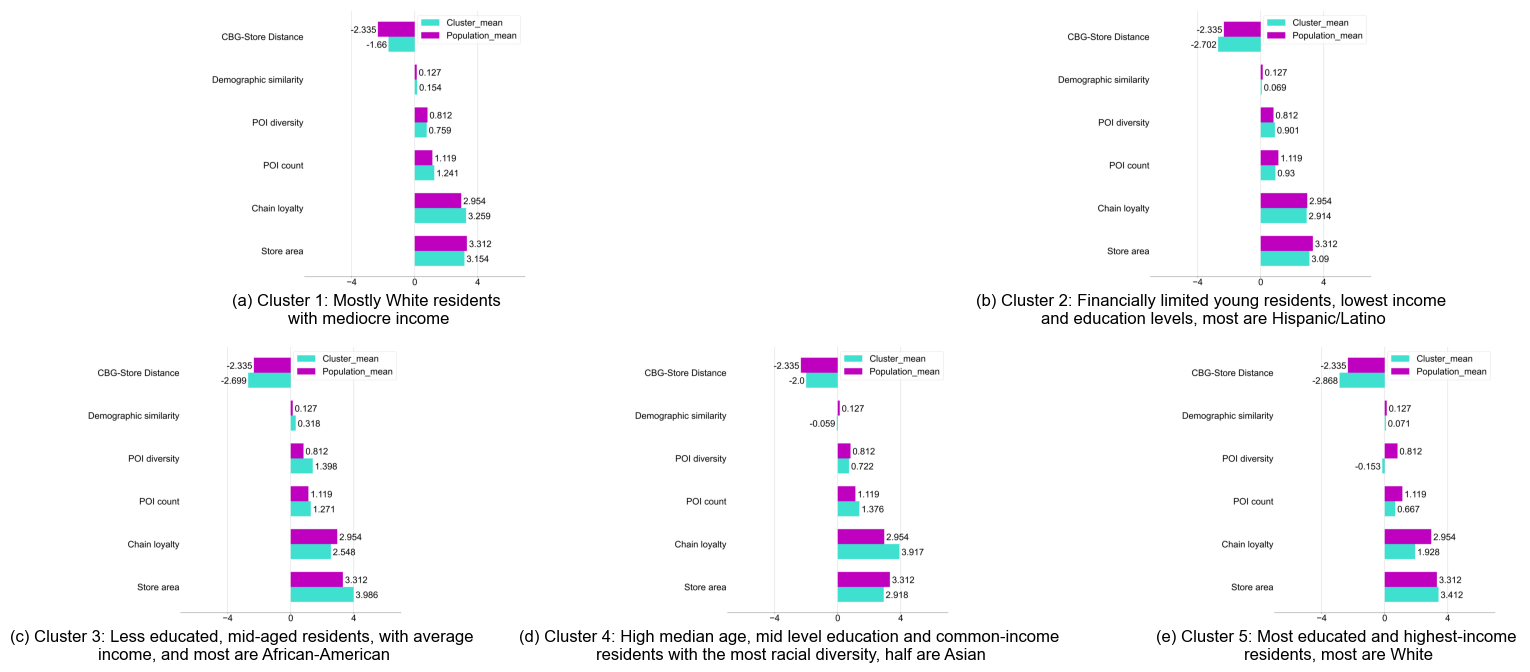

In [23]:
Image1 = Image.open(
    '2020/2020 Delta Value Mean Comparisons between Cluster 1 and Population.jpg')
Image2 = Image.open(
    '2020/2020 Delta Value Mean Comparisons between Cluster 2 and Population.jpg')
Image3 = Image.open(
    '2020/2020 Delta Value Mean Comparisons between Cluster 3 and Population.jpg')
Image4 = Image.open(
    '2020/2020 Delta Value Mean Comparisons between Cluster 4 and Population.jpg')
Image5 = Image.open(
    '2020/2020 Delta Value Mean Comparisons between Cluster 5 and Population.jpg')
fig = plt.figure(figsize=(20, 8))

# Adds a subplot at the 1st position
fig.add_subplot(2, 2, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("(a) Cluster 1: Mostly White residents \nwith mediocre income", y=-0.15)
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 2, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("(b) Cluster 2: Financially limited young residents, lowest income \nand education levels, most are Hispanic/Latino", y=-0.15)
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 3, 4)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("(c) Cluster 3: Less educated, mid-aged residents, with average \nincome, and most are African-American", y=-0.15)
  
# Adds a subplot at the 4th position
fig.add_subplot(2, 3, 5)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("(d) Cluster 4: High median age, mid level education and common-income \nresidents with the most racial diversity, half are Asian", y=-0.15)

# # Adds a subplot at the 5th position
fig.add_subplot(2, 3, 6)
  
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("(e) Cluster 5: Most educated and highest-income \nresidents, most are White", y=-0.15)

plt.savefig(
        'kmeans_cluster_param_delta_change_combination_2020.jpg', 
                dpi=300, bbox_inches='tight')

plt.show()

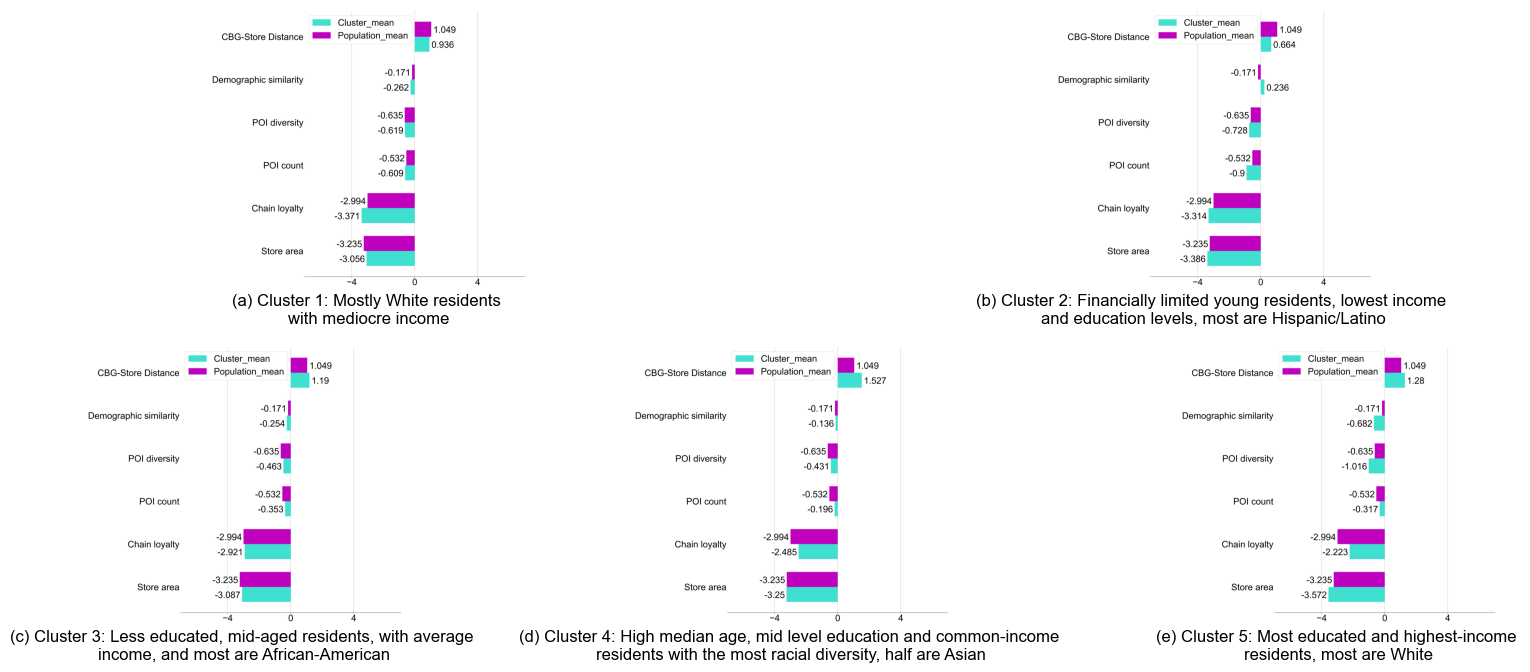

In [24]:
Image1 = Image.open(
    '2021/2021 Delta Value Mean Comparisons between Cluster 1 and Population.jpg')
Image2 = Image.open(
    '2021/2021 Delta Value Mean Comparisons between Cluster 2 and Population.jpg')
Image3 = Image.open(
    '2021/2021 Delta Value Mean Comparisons between Cluster 3 and Population.jpg')
Image4 = Image.open(
    '2021/2021 Delta Value Mean Comparisons between Cluster 4 and Population.jpg')
Image5 = Image.open(
    '2021/2021 Delta Value Mean Comparisons between Cluster 5 and Population.jpg')
fig = plt.figure(figsize=(20, 8))

# Adds a subplot at the 1st position
fig.add_subplot(2, 2, 1)
  
# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("(a) Cluster 1: Mostly White residents \nwith mediocre income", y=-0.15)
  
# Adds a subplot at the 2nd position
fig.add_subplot(2, 2, 2)
  
# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("(b) Cluster 2: Financially limited young residents, lowest income \nand education levels, most are Hispanic/Latino", y=-0.15)
  
# Adds a subplot at the 3rd position
fig.add_subplot(2, 3, 4)
  
# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("(c) Cluster 3: Less educated, mid-aged residents, with average \nincome, and most are African-American", y=-0.15)
  
# Adds a subplot at the 4th position
fig.add_subplot(2, 3, 5)
  
# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("(d) Cluster 4: High median age, mid level education and common-income \nresidents with the most racial diversity, half are Asian", y=-0.15)

# # Adds a subplot at the 5th position
fig.add_subplot(2, 3, 6)
  
# showing image
plt.imshow(Image5)
plt.axis('off')
plt.title("(e) Cluster 5: Most educated and highest-income \nresidents, most are White", y=-0.15)

plt.savefig(
        'kmeans_cluster_param_delta_change_combination_2021.jpg', 
                dpi=300, bbox_inches='tight')

plt.show()